# Semantic Segmentation project 2 PH dataset

We provide you with a class similar to the Hotdog_NotHotdog data loader that will allow you to load the dataset from  /dtu/datasets1/02514/

First, we load some needed libraries

In [37]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
import random
from omegaconf import OmegaConf

from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateFinder

from src.utils import accuracy, specificity, sensitivity, iou, dice
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [18, 6]

Next, the data loader

In [38]:
!ls '/dtu/datasets1/02514/PH2_Dataset_images/IMD003/IMD003_lesion'
# !ls '/dtu/datasets1/02514/DRIVE'

IMD003_lesion.bmp


In [39]:
data_path = '/dtu/datasets1/02514/PH2_Dataset_images'

In [ ]:
a = Image.open('/dtu/datasets1/02514/PH2_Dataset_images/IMD002/IMD002_roi/IMD002_R1_Label4.bmp')
b = Image.open('/dtu/datasets1/02514/PH2_Dataset_images/IMD002/IMD002_roi/IMD002_R2_Label3.bmp')
c = Image.open('/dtu/datasets1/02514/PH2_Dataset_images/IMD002/IMD002_lesion/IMD002_lesion.bmp')
d = Image.open('/dtu/datasets1/02514/PH2_Dataset_images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp')
fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow([a,b,c,d][i])

In [41]:
image_paths = glob.glob(data_path + '/*/*_Dermoscopic_Image/*.bmp')
label_paths = glob.glob(data_path + '/*/*_lesion/*.bmp')
all_sizes = []
for i_path, l_path in zip(image_paths, label_paths):
    all_sizes.append(Image.open(i_path).size)
    all_sizes.append(Image.open(l_path).size)
    

In [42]:
print(len(set(all_sizes)))
print(set(all_sizes))

24
{(768, 576), (769, 575), (762, 572), (761, 570), (766, 572), (766, 575), (764, 572), (765, 573), (764, 575), (769, 577), (767, 576), (764, 574), (763, 575), (765, 572), (765, 575), (768, 574), (768, 577), (761, 571), (761, 574), (763, 553), (766, 576), (767, 575), (764, 576), (765, 574)}


### Considerations
from: https://www.mdpi.com/2075-4418/9/3/72
- All images are 8-bit RGB images with 768 × 560 pixels resolution and were taken by using a lens with a magnification of 20×
    - these are the ones we have, thus we resize the the /2 of this

In [43]:

class PH2_dataset(torch.utils.data.Dataset):
    def __init__(self, mode, transform, data_path=data_path):
        # Initialization
        self.transform = transform
        self.image_paths = glob.glob(data_path + '/*/*_Dermoscopic_Image/*.bmp')
        self.label_paths = glob.glob(data_path + '/*/*_lesion/*.bmp')
        c = list(zip(self.image_paths, self.label_paths))

        random.shuffle(c)
        self.image_paths, self.label_paths = zip(*c)        

        train_size = int(0.7 * len(self.image_paths))
        val_size = int(0.1 * len(self.image_paths))

        if mode == 'train':
            self.image_paths = self.image_paths[:train_size]
            self.label_paths = self.label_paths[:train_size]

        elif mode == 'val':
            self.image_paths = self.image_paths[train_size:train_size+val_size]
            self.label_paths = self.label_paths[train_size:train_size+val_size]

        elif mode == 'test':
            self.image_paths = self.image_paths[train_size+val_size:]
            self.label_paths = self.label_paths[train_size+val_size:]

        else:
            raise ValueError('mode must be one of train, val or test')

        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path)
        label = Image.open(label_path)
        Y = 1*self.transform(label)
        X = self.transform(image)
        return X, Y

In [44]:
division = 1

# won't work since halving in the CNN structure will end up with and uneven number
#size = (int(560/division), int(768/division))
h, w = 256, 256
# size = (int(h/division), int(w/division))
size = (288, 384)

train_transform = transforms.Compose([transforms.Resize(size), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(size), 
                                    transforms.ToTensor()])

batch_size = 6
trainset = PH2_dataset(mode='train', transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
valset = PH2_dataset(mode='val', transform=train_transform)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = PH2_dataset(mode='test', transform=train_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=3)

In principle, the images could have different sizes. Let's resize them all to $128\times128$ pixels, using the torchvision Resize. 

In [45]:
print('Loaded %d training images' % len(trainset))
print('Loaded %d validation images' % len(valset))
print('Loaded %d test images' % len(testset))

Loaded 140 training images
Loaded 20 validation images
Loaded 40 test images


Let's look at some images from the dataset!

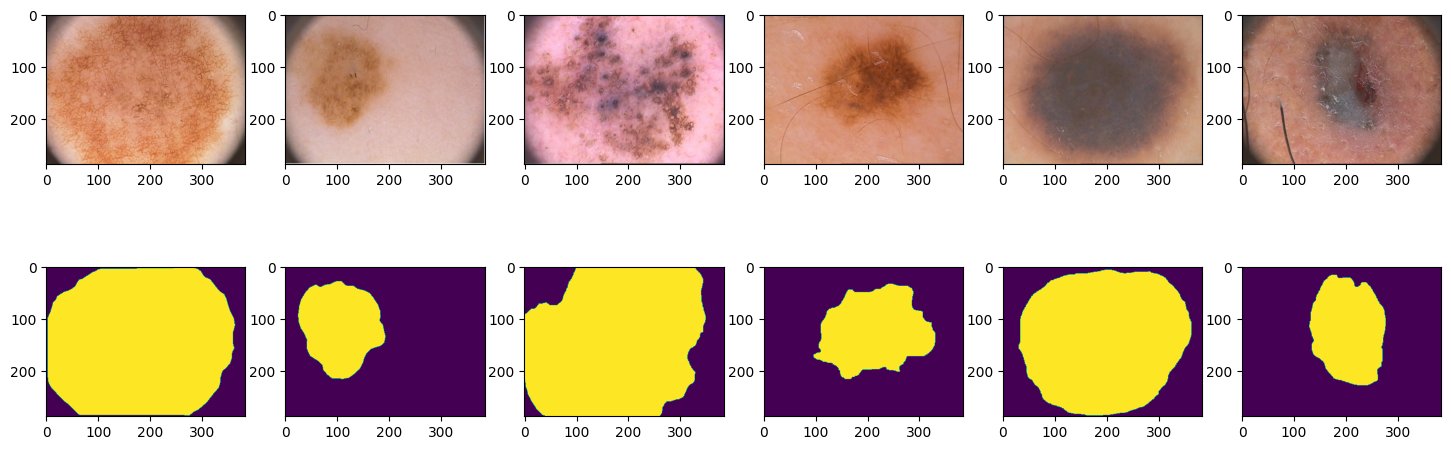

In [ ]:
images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

In [ ]:
loaders = {'train': train_loader, 'validation': val_loader, 'test': test_loader}

### Considerations:
- images are typically centered and edges are irrelevant
    - thus UNet is appropriate

## Device

Check if GPU is available.

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Modelling

In [179]:
import os
user = os.environ['USER']

In [180]:
# Define arguments
args = OmegaConf.create({
    'experiment_name': 'test',
    'network_name': 'test',

    'data_path': '/dtu/datasets1/02514/PH2_Dataset_images',
    'log_path': f'/work3/{user}/02514/DL-COMVIS/logs/project2',
    'save_path': f'/work3/{user}/02514/DL-COMVIS/models/project2',
    
    'seed': 0,
    'verbose': False,
    'log_every_n': 2,

    'batch_size': 6,
    'optimizer': 'Adam',
    'lr': 1e-3,
    'initial_lr_steps': -1,
    'epochs': 20,
    'num_workers': 24,
    'devices': -1,
    'verbose': False,
})


In [181]:

### BASEMODEL ###
class BaseModel(pl.LightningModule):
    def __init__(self, args, loss_fun, logs, metrics, optimizer):
        super().__init__()
        self.args = args
        self.lr = self.args.lr
        self.loss_fun = loss_fun
        self.logs = logs
        self.metrics = metrics
        self.optimizer = optimizer
        self.log_dict = {}
        
        # checkpointing and logging
        self.model_checkpoint = ModelCheckpoint(
            monitor = "val_loss",
            verbose = args.verbose,
            filename = "{epoch}_{val_loss:.4f}",
        )
        
        self.save_hyperparameters()

    def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr = self.args.lr)
        
    def training_step(self, batch, batch_idx):
        # extract input
        x, y = batch
        # predict
        y_hat = self.forward(x)
        # loss
        loss = self.loss_fun(y, y_hat)
        # metrics
        y_hat_sig = F.sigmoid(y_hat)
        threshold = torch.tensor([0.5],device=device)

        y_hat_sig = (y_hat_sig>threshold).float()*1
        y_hat_sig = y_hat_sig.int()
        y = y.int()
        # log
        for name, fun in self.logs.items():
            self.log('train_'+name, fun(y_hat_sig, y), prog_bar=True, logger=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # extract input
        x, y = batch
        # predict
        y_hat = self.forward(x)
        # loss
        loss = self.loss_fun(y, y_hat)
        y_hat_sig = F.sigmoid(y_hat)
        threshold = torch.tensor([0.5],device=device)

        y_hat_sig = (y_hat_sig>threshold).float()*1
        y_hat_sig = y_hat_sig.int()
        y = y.int()
        # log
        for name, fun in self.logs.items():
            self.log('val_'+name, fun(y_hat_sig, y), prog_bar=True, logger=True)
        for name, fun in self.metrics.items():
            self.log('val_'+name, fun(y_hat_sig, y))
        self.log("val_loss", loss, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx): 
        # extract input
        x, y = batch
        # predict
        y_hat = self.forward(x)
        # loss
        loss = self.loss_fun(y, y_hat)
        # predicting
        y_hat_sig = F.sigmoid(y_hat)#.detach().cpu() # todo?
        threshold = torch.tensor([0.5],device=device)

        y_hat_sig = (y_hat_sig>threshold).float()*1
        y_hat_sig = y_hat_sig.int()
        y = y.int()
        # getting output values
        self.log('Test loss', loss) #, prog_bar=True)
        for name, fun in self.logs.items():
            self.log('Test '+name, fun(y_hat_sig, y))
        for name, fun in self.metrics.items():
            self.log('Test '+name, fun(y_hat_sig, y))


In [182]:
class EncDec(BaseModel):
    def __init__(self, args, loss_fun, logs, metrics, optimizer):
        super().__init__(args, loss_fun, logs, metrics, optimizer)
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)
    
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3


In [183]:
# define parameters
def bce_loss(y_real, y_pred):
    return F.binary_cross_entropy_with_logits(y_pred, y_real,
                                              pos_weight=torch.tensor([0.5],device=device))

loss_fun = bce_loss
optimizer = optim.Adam
logs = {
    'acc': accuracy,
}

metrics = {
    'Dice overlap': dice,
    'IoU'         : iou,
    'Sensitivity' : sensitivity,
    'Specificity' : specificity,
}

In [143]:
# define model
model = EncDec(args, loss_fun, logs, metrics, optimizer).to(device)


In [144]:
summary(model, (3, 288, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 288, 384]           1,792
         MaxPool2d-2         [-1, 64, 144, 192]               0
            Conv2d-3         [-1, 64, 144, 192]          36,928
         MaxPool2d-4           [-1, 64, 72, 96]               0
            Conv2d-5           [-1, 64, 72, 96]          36,928
         MaxPool2d-6           [-1, 64, 36, 48]               0
            Conv2d-7           [-1, 64, 36, 48]          36,928
         MaxPool2d-8           [-1, 64, 18, 24]               0
            Conv2d-9           [-1, 64, 18, 24]          36,928
         Upsample-10           [-1, 64, 36, 48]               0
           Conv2d-11           [-1, 64, 36, 48]          36,928
         Upsample-12           [-1, 64, 72, 96]               0
           Conv2d-13           [-1, 64, 72, 96]          36,928
         Upsample-14         [-1, 64, 1

## Training

In [145]:
# Set up logger

tb_logger = TensorBoardLogger(
    save_dir=f"{args.log_path}/{args.experiment_name}",
    version=None,
    name=args.network_name,
)


# Setup trainer
trainer = pl.Trainer(
    devices=args.devices, 
    accelerator='gpu', 
    max_epochs = args.epochs,
    log_every_n_steps = args.log_every_n,
    callbacks=[model.model_checkpoint] if args.initial_lr_steps == -1 else [model.model_checkpoint, model.lr_finder],
    logger=tb_logger,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [146]:
# Train model
trainer.fit(
    model=model,
    train_dataloaders = loaders['train'],
    val_dataloaders = loaders['validation'], 
) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

   | Name            | Type      | Params
-----------------------------------------------
0  | enc_conv0       | Conv2d    | 1.8 K 
1  | pool0           | MaxPool2d | 0     
2  | enc_conv1       | Conv2d    | 36.9 K
3  | pool1           | MaxPool2d | 0     
4  | enc_conv2       | Conv2d    | 36.9 K
5  | pool2           | MaxPool2d | 0     
6  | enc_conv3       | Conv2d    | 36.9 K
7  | pool3           | MaxPool2d | 0     
8  | bottleneck_conv | Conv2d    | 36.9 K
9  | upsample0       | Upsample  | 0     
10 | dec_conv0       | Conv2d    | 36.9 K
11 | upsample1       | Upsample  | 0     
12 | dec_conv1       | Conv2d    | 36.9 K
13 | upsample2       | Upsample  | 0     
14 | dec_conv2       | Conv2d    | 36.9 K
15 | upsample3       | Upsample  | 0     
16 | dec_conv3       | Conv2d    | 577   
-----------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.043     Total estimate

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
trainer.test(model, dataloaders=loaders['test'])

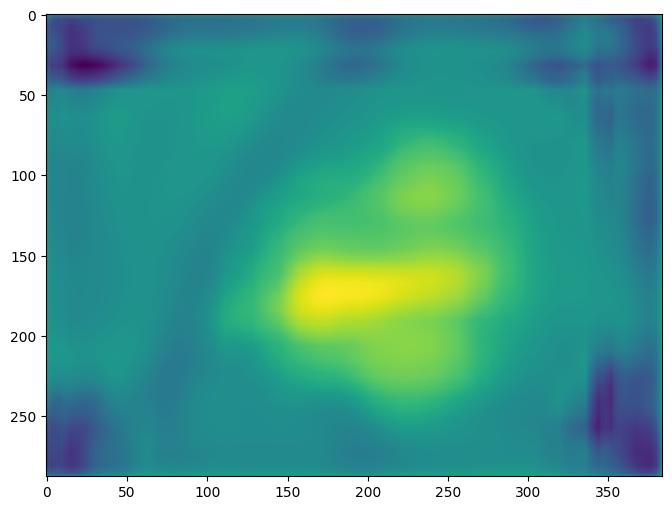

In [95]:
x = next(iter(loaders['test']))[0]
plt.imshow(model(x).detach().numpy()[0].transpose(1,2,0))

# U-Net model

In [184]:
def bce_loss(y, y_hat):
    return F.binary_cross_entropy_with_logits(y_hat, y,
                                              pos_weight=torch.tensor([0.5],device=device))

loss_fun = bce_loss
optimizer = optim.Adam
logs = {
    'acc': accuracy,
}

metrics = {
    'Dice overlap': dice,
    'IoU'         : iou,
    'Sensitivity' : sensitivity,
    'Specificity' : specificity,
}

In [187]:
class UNet2(BaseModel):
    def __init__(self, args, loss_fun, logs, metrics, optimizer):
        super().__init__(args, loss_fun, logs, metrics, optimizer)
    

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # nn.MaxPool2d(2, 2)  # 128 -> 64

        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # nn.MaxPool2d(2, 2)  # 64 -> 32

        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # nn.MaxPool2d(2, 2)  # 32 -> 16

        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(64, 64, 3, padding=1, stride=2, output_padding=1) #nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(64, 64, 3, padding=1, stride=2, output_padding=1) # nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)

        self.upsample2 = nn.ConvTranspose2d(64, 64, 3, padding=1, stride=2, output_padding=1) #nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        
        self.upsample3 = nn.ConvTranspose2d(64, 64, 3, padding=1, stride=2, output_padding=1) # nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e0_pool = self.pool0(e0)
        e1 = F.relu(self.enc_conv1(e0_pool))
        e1_pool = self.pool1(e1)
        e2 = F.relu(self.enc_conv2(e1_pool))
        e2_pool = self.pool2(e2)
        e3 = F.relu(self.enc_conv3(e2_pool))
        e3_pool = self.pool3(e3)

        # print(e3_pool.shape)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3_pool))
        # print("b", b.shape)

        # decoder - # Concatenating last encoder layer to first decode, within the relu
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b), e3], dim = 1)))
        # print("d0", d0.shape)
        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim = 1)))
        # print("d1", d1.shape)
        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim = 1)))
        # print("d2", d2.shape)
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim = 1))
        # I think this is correct, as the last layer should

        return d3

In [188]:
# define model
model = UNet2(args, loss_fun, logs, metrics, optimizer).to(device)


In [189]:
summary(model, (3, 288, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 288, 384]           1,792
            Conv2d-2         [-1, 64, 144, 192]          36,928
            Conv2d-3         [-1, 64, 144, 192]          36,928
            Conv2d-4           [-1, 64, 72, 96]          36,928
            Conv2d-5           [-1, 64, 72, 96]          36,928
            Conv2d-6           [-1, 64, 36, 48]          36,928
            Conv2d-7           [-1, 64, 36, 48]          36,928
            Conv2d-8           [-1, 64, 18, 24]          36,928
            Conv2d-9           [-1, 64, 18, 24]          36,928
  ConvTranspose2d-10           [-1, 64, 36, 48]          36,928
           Conv2d-11           [-1, 64, 36, 48]          73,792
  ConvTranspose2d-12           [-1, 64, 72, 96]          36,928
           Conv2d-13           [-1, 64, 72, 96]          73,792
  ConvTranspose2d-14         [-1, 64, 1

## Training

In [190]:
# Set up logger

tb_logger = TensorBoardLogger(
    save_dir=f"{args.log_path}/{args.experiment_name}",
    version=None,
    name=args.network_name,
)


# Setup trainer
trainer = pl.Trainer(
    devices=args.devices, 
    accelerator='gpu', 
    max_epochs = args.epochs,
    log_every_n_steps = args.log_every_n,
    callbacks=[model.model_checkpoint] if args.initial_lr_steps == -1 else [model.model_checkpoint, model.lr_finder],
    logger=tb_logger,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [191]:
# Train model
trainer.fit(
    model=model,
    train_dataloaders = loaders['train'],
    val_dataloaders = loaders['validation'], 
) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

   | Name            | Type            | Params
-----------------------------------------------------
0  | enc_conv0       | Conv2d          | 1.8 K 
1  | pool0           | Conv2d          | 36.9 K
2  | enc_conv1       | Conv2d          | 36.9 K
3  | pool1           | Conv2d          | 36.9 K
4  | enc_conv2       | Conv2d          | 36.9 K
5  | pool2           | Conv2d          | 36.9 K
6  | enc_conv3       | Conv2d          | 36.9 K
7  | pool3           | Conv2d          | 36.9 K
8  | bottleneck_conv | Conv2d          | 36.9 K
9  | upsample0       | ConvTranspose2d | 36.9 K
10 | dec_conv0       | Conv2d          | 73.8 K
11 | upsample1       | ConvTranspose2d | 36.9 K
12 | dec_conv1       | Conv2d          | 73.8 K
13 | upsample2       | ConvTranspose2d | 36.9 K
14 | dec_conv2       | Conv2d          | 73.8 K
15 | upsample3       | ConvTranspose2d | 36.9 K
16 | dec_conv3       | Conv2d          | 1.2 K 
---------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [192]:
trainer.test(model, dataloaders=loaders['test'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Test Dice overlap     │    0.7875149846076965     │
│         Test IoU          │    0.6547328233718872     │
│     Test Sensitivity      │    0.6792536973953247     │
│     Test Specificity      │    0.9822659492492676     │
│         Test acc          │    0.8873897790908813     │
│         Test loss         │    0.19444219768047333    │
└───────────────────────────┴───────────────────────────┘

[{'Test loss': 0.19444219768047333,
  'Test acc': 0.8873897790908813,
  'Test Dice overlap': 0.7875149846076965,
  'Test IoU': 0.6547328233718872,
  'Test Sensitivity': 0.6792536973953247,
  'Test Specificity': 0.9822659492492676}]

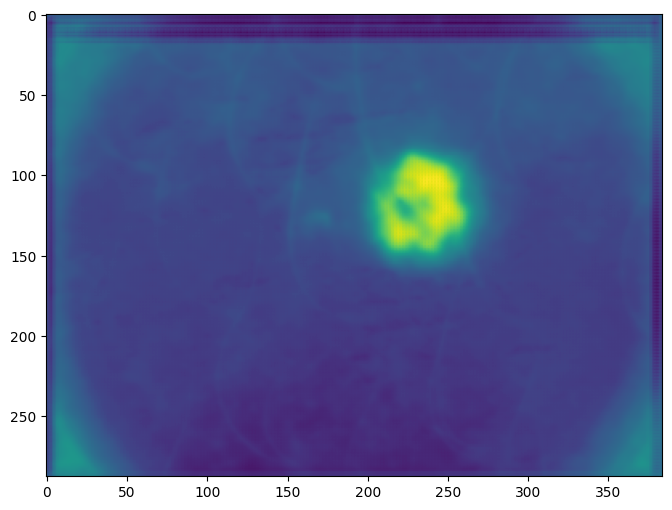

In [193]:
x = next(iter(loaders['test']))[0]
plt.imshow(model(x).detach().numpy()[0].transpose(1,2,0))